<a href="https://colab.research.google.com/github/yukaberry/detect_ai_content/blob/development/notebooks/texts/lina_text_internal_features_tuned.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install xgboost lightgbm
!pip install textstat
!pip install nltk

In [38]:
pip install pyspellchecker

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 42.5 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


# Text and NLP Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
import spacy
import textstat
from textblob import TextBlob
from transformers import pipeline


# Load Spacy model for NLP
nlp = spacy.load("en_core_web_sm")

import nltk
nltk.download('punkt', force=True)
nltk.download('stopwords', force=True)
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
from google.colab import files
uploaded = files.upload()

In [46]:
df = pd.read_csv('new_dataset.csv')
df.head()

,text,generated
0,"Furthermore, the additional hours spent in sch...",1.0
1,other student have their young ones at home wh...,0.0
2,Always set a goal for yourself.\n\nEveryone in...,0.0
3,"Additionally, online classes often provide add...",1.0
4,Cars have bin around for awhile and this have ...,0.0


# Functions

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

#Text-Based

In [70]:


def text_based_features(text_df, text_column='text'):
    features = pd.DataFrame()

    # Ensure stopwords are loaded
    stop_words = set(stopwords.words('english'))

    # Word count
    features['word_count'] = text_df[text_column].apply(lambda x: len(word_tokenize(x)))

    # Sentence count
    features['sentence_count'] = text_df[text_column].apply(lambda x: len(sent_tokenize(x)))

    # Average word length
    features['avg_word_length'] = text_df[text_column].apply(lambda x: np.mean([len(word) for word in word_tokenize(x)]))

    # Stopwords count
    features['stopwords_count'] = text_df[text_column].apply(lambda x: sum(1 for word in word_tokenize(x) if word.lower() in stop_words))

    return features

In [71]:
text_features = text_based_features(df, text_column='text')

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


#Lexical Diversity and Readability Scores

Libraries in use : NLTK--> tokenization, Textstast--> calculate scores: built -in fucntions

Lexical diversity measures the variety of words in text, indicating richness in vocabulary, while readability scores assess how easy a text is to read. Readability metrics such as the Flesch Reading Ease and Dale-Chall Score are used.

Lexical Diversity: Measures the variety of words in a text. A higher lexical diversity means a richer vocabulary, while a lower one suggests repetitive or simpler language.

Readability Scores: These scores quantify how easy or difficult it is to read a given text. Higher scores generally indicate simpler texts, while lower scores imply more complex language.

• Flesch Reading Ease: A higher score --> simpler text, easy to read

• SMOG Index: Measures the years of education needed to understand a piece of writing. B)

• Flesch-Kincaid Grade Level: Indicates the U.S. school grade level required to understand the text.

In [48]:
def lexical_diversity_readability(text_df, text_column='text'):
    features = pd.DataFrame()

    # Lexical diversity (Unique words / Total words)
    features['lexical_diversity'] = text_df[text_column].apply(lambda x: len(set(word_tokenize(x))) / len(word_tokenize(x)) if len(word_tokenize(x)) > 0 else 0)

    # Readability Scores
    features['flesch_reading_ease'] = text_df[text_column].apply(textstat.flesch_reading_ease)
    features['smog_index'] = text_df[text_column].apply(textstat.smog_index)
    features['flesch_kincaid_grade'] = text_df[text_column].apply(textstat.flesch_kincaid_grade)

    return features

#POS Tagging Features
Part of Speech (POS) tagging helps identify grammatical structures in text, such as noun and verb counts. By examining POS distributions, we can highlight stylistic differences that may distinguish AI-generated text from human-generated text.

Libraries in use: SpaCy (nlp): Used for natural language processing, specifically to tokenize text and retrieve POS tags.

In [49]:
def pos_tagging_features(text_df, text_column='text'):
    pos_features = pd.DataFrame()

    def pos_counts(text):
        doc = nlp(text) # text parsing
        pos_counts = {token.pos_: 0 for token in doc} # dictionary with POS tags (like NOUN, VERB, ADJ)
        for token in doc:
            pos_counts[token.pos_] += 1
        return pos_counts

    pos_df = text_df[text_column].apply(pos_counts).apply(pd.Series).fillna(0) # Fill missing POS tag counts with 0 for consistency across texts

    pos_df.columns = [f'pos_{col}' for col in pos_df.columns]
    pos_features = pd.concat([pos_features, pos_df], axis=1)

    return pos_features

#Sentiment and Emotion
Sentiment (Transformers): General sentiment (POSITIVE, NEGATIVE, NEUTRAL)

Polarity (TextBlob): Degree of positivity or negativity, from -1 to 1. Hope has 1 polarity, terrible -1

Subjectivity (TextBlob): Extent of personal opinion, from 0 to 1. " I think" --> 1

In [50]:
def sentiment_emotion_features(text_df, text_column='text'):
    features = pd.DataFrame()

    # Initialize sentiment analysis pipeline with GPU (device=0)
    sentiment_pipeline = pipeline('sentiment-analysis', device=0, truncation=True, max_length=512)

    # Apply sentiment analysis in batches
    texts = text_df[text_column].tolist()
    sentiment_results = sentiment_pipeline(texts, truncation=True, max_length=512, batch_size=32)

    # Extract sentiment labels from the results
    features['sentiment'] = [result['label'] for result in sentiment_results]

    # Polarity and subjectivity from TextBlob
    features['polarity'] = text_df[text_column].apply(lambda x: TextBlob(x).sentiment.polarity)
    features['subjectivity'] = text_df[text_column].apply(lambda x: TextBlob(x).sentiment.subjectivity)

    return features

## N-grams and Keyword Features

N-gram : sequence of n adjancent words in a sentence,
- Ex: “The product is great,” the bigrams are:
"The product” - "product is" -  "product is great"
- “Humans and AI can collaborate.” the triagrams

In [51]:
def ngrams_keyword_features(text_df, text_column='text'):
    features = pd.DataFrame()

    # Bi-grams count
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    bigram_matrix = vectorizer.fit_transform(text_df[text_column])
    features['bigram_count'] = bigram_matrix.sum(axis=1).A1

    # Trigrams count
    vectorizer = CountVectorizer(ngram_range=(3, 3))
    trigram_matrix = vectorizer.fit_transform(text_df[text_column])
    features['trigram_count'] = trigram_matrix.sum(axis=1).A1 # .A1 converts the sparse column vector into a 1-d np array, to work with pd df columns.

    return features

#Linguistic Complexity Features

Analyze the complexity of sentences, including the number of clauses and the depth of syntactic structures.

Dependency structures : its like parts of the sentence that helps to make sense, like names of people, places, or things being talked about.

" The dog runs”...low complexity, entities : none, dependency count 0

" Jerome is a french experienced ios developer " ...high complexity, entities: 3 , count dependency = 3

In [52]:
# Load SpaCy's English model with only NER (for named entity recognition)
nlp = spacy.load("en_core_web_sm", disable=["tagger", "parser", "lemmatizer"])

def linguistic_complexity_features(text_df, text_column='text'):
    features = pd.DataFrame()

    # Process text in batches to improve efficiency
    docs = nlp.pipe(text_df[text_column], batch_size=32)  # Adjust batch size as needed for performance
    features['dependency_count'] = [len(doc.ents) for doc in docs]

    return features

# Error-Check

In [53]:
from spellchecker import SpellChecker

def spelling_error_features(text_df, text_column='text'):
    features = pd.DataFrame()
    spell = SpellChecker()

    def count_spelling_errors(text):
        words = text.split()
        misspelled_words = spell.unknown(words)
        return len(misspelled_words)

    features['spelling_errors'] = text_df[text_column].apply(count_spelling_errors)
    return features

#Repetition Detection Function
This function will calculate the frequency of repeated phrases or words. We’ll use Counter from the collections module to count repeated words or phrases in the text.

In [54]:
from collections import Counter
import pandas as pd

def repetition_features(text_df, text_column='text', n=2):
    features = pd.DataFrame()

    def detect_repetition(text):
        words = text.split()
        phrases = [' '.join(words[i:i+n]) for i in range(len(words) - n + 1)]
        phrase_counts = Counter(phrases)
        repeated_phrases = {phrase: count for phrase, count in phrase_counts.items() if count > 1}
        return len(repeated_phrases)  # count of unique repeated phrases

    features['repetition_count'] = text_df[text_column].apply(detect_repetition)

    return features

#Structural and Formatting Features
Capture line breaks, indentation, or special formatting often present in human-written text.

Human texts often have structured paragraphing and a varied use of punctuation for emphasis and clarity...

In [55]:
def structural_formatting_features(text_df, text_column='text'):
    features = pd.DataFrame()

    # Line break count
    features['line_break_count'] = text_df[text_column].apply(lambda x: x.count('\n'))

    # Punctuation count
    features['punctuation_count'] = text_df[text_column].apply(lambda x: sum([1 for char in x if char in '.,;!?']))

    return features

# Slang

In [56]:
import requests
import json

def randomword():
    response = requests.get("https://api.urbandictionary.com/v0/random")

    return response.text

In [57]:
slang_dict = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk",
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart",
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "IG" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet",
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously",
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

In [58]:

def count_slang(text, slang_dict):

    # maybe you need to add cleaning test function here below
    # it will depend on txt dataset
    # ex) text = clean_txt(text)

    slang_count = sum(1 for word in text if word in slang_dict)
    return slang_count

# Calling the Functions

In [65]:
text_features = text_based_features(df, text_column='text')

LookupError: 
**********************************************************************
  Resource [93mpunkt_tab[0m not found.
  Please use the NLTK Downloader to obtain the resource:

  [31m>>> import nltk
  >>> nltk.download('punkt_tab')
  [0m
  For more information see: https://www.nltk.org/data.html

  Attempted to load [93mtokenizers/punkt_tab/english/[0m

  Searched in:
    - '/root/nltk_data'
    - '/usr/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/share/nltk_data'
    - '/usr/local/share/nltk_data'
    - '/usr/lib/nltk_data'
    - '/usr/local/lib/nltk_data'
**********************************************************************


In [ ]:
lexical_features = lexical_diversity_readability(df, text_column='text')

In [ ]:
pos_features = pos_tagging_features(df, text_column='text')

In [ ]:
sentiment_features = sentiment_emotion_features(df, text_column='text')

In [ ]:
ngram_features = ngrams_keyword_features(df, text_column='text')

In [ ]:
complexity_features = linguistic_complexity_features(df, text_column='text')

In [ ]:
structural_features = structural_formatting_features(df, text_column='text')

In [ ]:
repetition_features = repetition_features(df, text_column='text')

In [ ]:
spelling_error_features = spelling_error_features(df, text_column='text')

In [ ]:
slang = count_slang(text, slang_dict)

In [ ]:

# Concatenate internal features
internal_features = pd.concat([
    text_features,
    lexical_features,
    pos_features,
    sentiment_features,
    ngram_features,
    complexity_features,
    structural_features,
    repetition_features,
    spelling_error_features
    slang
], axis=1)

In [ ]:
internal_df = pd.concat([df[['generated', 'text']], internal_features], axis=1)
internal_df.shape

In [ ]:
internal_df.head()

In [ ]:
def aggregate_internal_features(internal_df):
    aggregated_features = pd.DataFrame()

    # Useful ratios
    aggregated_features['word_count_ratio'] = internal_df['word_count'] / internal_df['sentence_count']
    aggregated_features['stopwords_ratio'] = internal_df['stopwords_count'] / internal_df['word_count']
    aggregated_features['punctuation_ratio'] = internal_df['punctuation_count'] / internal_df['word_count']
    aggregated_features['repetition_ratio'] = internal_df['repetition_count'] / internal_df['word_count']
    aggregated_features['bigram_count_ratio'] = internal_df['bigram_count'] / internal_df['word_count']
    aggregated_features['trigram_count_ratio'] = internal_df['trigram_count'] / internal_df['word_count']
    aggregated_features['dependency_ratio'] = internal_df['dependency_count'] / internal_df['sentence_count']
    aggregated_features['spelling_errors_ratio'] = internal_df['spelling_errors'] / internal_df['word_count']

    # POS tag ratios and any directly included specific features
    pos_columns = [col for col in internal_df.columns if 'pos_' in col]
    for pos_col in pos_columns:
        aggregated_features[f'{pos_col}_ratio'] = internal_df[pos_col] / internal_df['word_count']

    # Retain specific features directly
    retained_features = internal_df[['avg_word_length', 'lexical_diversity', 'flesch_reading_ease', 'smog_index',
                                     'flesch_kincaid_grade', 'polarity', 'subjectivity', 'slang']].copy()

    # Encode sentiment feature as numeric values for correlation analysis
    sentiment_mapping = {'NEGATIVE': -1, 'NEUTRAL': 0, 'POSITIVE': 1}
    retained_features['sentiment'] = internal_df['sentiment'].map(sentiment_mapping)

    # Combine all features and include the 'generated' column
    final_internal_df = pd.concat([internal_df[['generated']], aggregated_features, retained_features], axis=1)

    return final_internal_df

# Now, you can call this function with your internal DataFrame
final_internal_df = aggregate_internal_features(internal_df)

# Display the head to confirm the structure
print(final_internal_df.head())


   generated  word_count_ratio  stopwords_ratio  punctuation_ratio  \
0        1.0         21.785714         0.426230           0.098361   
1        0.0         12.981481         0.530670           0.101284   
2        1.0         21.666667         0.400000           0.082051   
3        0.0         22.952381         0.545643           0.087137   
4        0.0         26.200000         0.366412           0.087786   

   repetition_ratio  bigram_count_ratio  trigram_count_ratio  \
0          0.072131            0.859016             0.855738   
1          0.099857            0.854494             0.853067   
2          0.051282            0.876923             0.871795   
3          0.101660            0.854772             0.852697   
4          0.034351            0.847328             0.843511   

   dependency_ratio  spelling_errors_ratio  pos__ratio  pos_SPACE_ratio  \
0          0.357143               0.114754    1.006557         0.013115   
1          0.018519               0.068474  

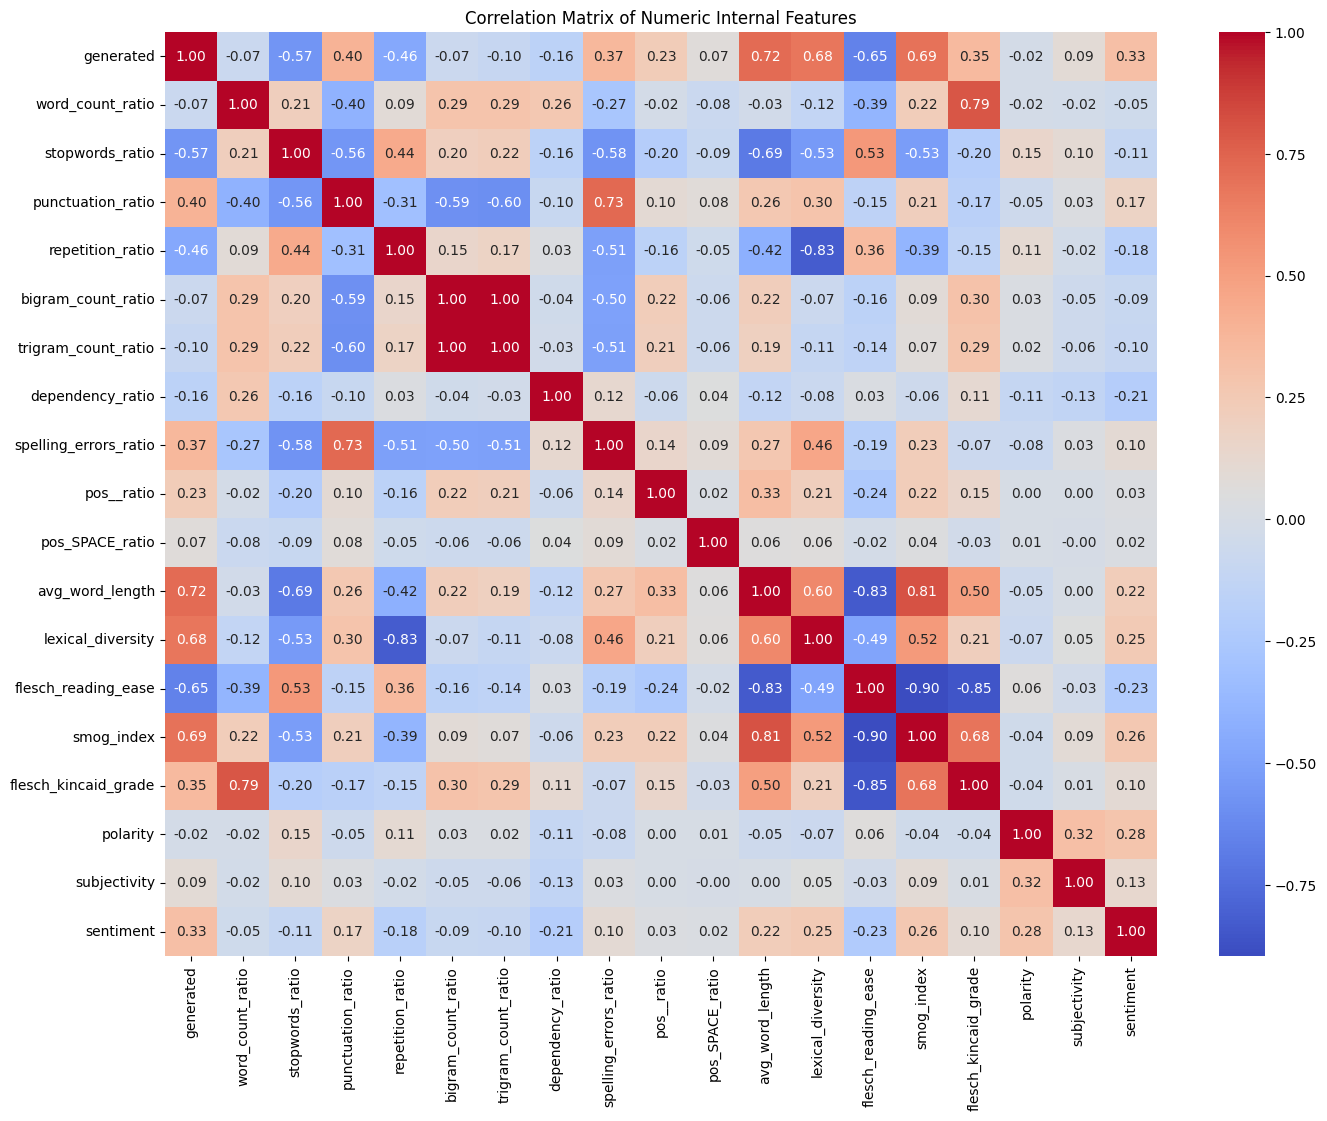

In [ ]:
import numpy as np

# Calculate and plot the correlation matrix for numeric features only
correlation_matrix = final_internal_df.corr()
plt.figure(figsize=(16, 12))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation Matrix of Numeric Internal Features")
plt.show()

In [ ]:
# Display the correlation of all features with 'generated'
correlation_internal= correlation_matrix['generated'].sort_values(ascending=False)
print("\nCorrelation with 'generated' column:\n", correlation_internal)


Correlation with 'generated' column:
 generated                1.000000
avg_word_length          0.722652
smog_index               0.690975
lexical_diversity        0.678662
punctuation_ratio        0.398543
spelling_errors_ratio    0.365555
flesch_kincaid_grade     0.348851
sentiment                0.325718
pos__ratio               0.234181
subjectivity             0.092225
pos_SPACE_ratio          0.071966
polarity                -0.019944
bigram_count_ratio      -0.068756
word_count_ratio        -0.074613
trigram_count_ratio     -0.097747
dependency_ratio        -0.159858
repetition_ratio        -0.461239
stopwords_ratio         -0.566064
flesch_reading_ease     -0.653542
Name: generated, dtype: float64


In [ ]:
from scipy.stats import pointbiserialr


<ipython-input-41-2c3a81addc30>:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=internal_correlation_df.index, y=internal_correlation_df['Correlation with generated'], palette='viridis')


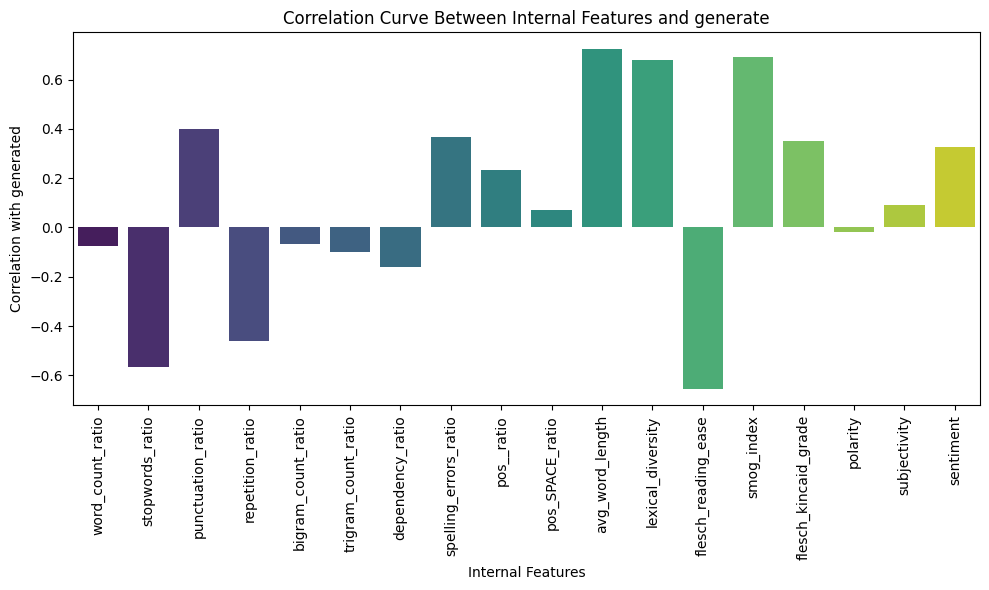

In [ ]:
# Calculate correlation for internal features
internal_correlations = {}
for col in final_internal_df.columns:
    if col != 'generated':  # Exclude the label column itself
        correlation, _ = pointbiserialr(final_internal_df[col], final_internal_df['generated'])
        internal_correlations[col] = correlation

# Convert to DataFrame for visualization
internal_correlation_df = pd.DataFrame.from_dict(internal_correlations, orient='index', columns=['Correlation with generated'])

# Plot correlation curve for internal features
plt.figure(figsize=(10, 6))
sns.barplot(x=internal_correlation_df.index, y=internal_correlation_df['Correlation with generated'], palette='viridis')
plt.xticks(rotation=90)
plt.xlabel('Internal Features')
plt.ylabel('Correlation with generated')
plt.title('Correlation Curve Between Internal Features and generate')
plt.tight_layout()
plt.show()


#Model Evaluation

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np

# Set correlation threshold
correlation_threshold = 0.1

# Step 1: Calculate correlation with the 'generated' column and filter features
correlation_with_target = final_internal_df.corr()['generated'].abs()
selected_features = correlation_with_target[correlation_with_target > correlation_threshold].index.drop('generated')

# Filter the dataset to only include selected features
X = final_internal_df[selected_features]
y = final_internal_df['generated']

# Step 2: Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Define the models to evaluate
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "SVM": SVC(probability=True),  # Enable probability for SVM to calculate AUC-ROC
    "Random Forest": RandomForestClassifier(),
    "XGBoost": XGBClassifier(),
    "LightGBM": LGBMClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Naive Bayes": GaussianNB(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier()
}

# Define a dictionary to store results
results = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1 Score": [],
    "AUC": []
}

# Function to train and evaluate each model
def evaluate_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else None

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob) if y_prob is not None else float('nan')

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'AUC': auc
    }

# Iterate over each model and store results
for name, model in models.items():
    print(f"Evaluating model: {name}")
    metrics = evaluate_model(model, X_train, X_test, y_train, y_test)
    results["Model"].append(name)
    results["Accuracy"].append(metrics["Accuracy"])
    results["Precision"].append(metrics["Precision"])
    results["Recall"].append(metrics["Recall"])
    results["F1 Score"].append(metrics["F1 Score"])
    results["AUC"].append(metrics["AUC"])

# Convert results dictionary to a DataFrame and display
results_df = pd.DataFrame(results)
print("\nModel Performance Comparison:")
print(results_df.to_string(index=False))

Evaluating model: Logistic Regression
Evaluating model: SVM
Evaluating model: Random Forest
Evaluating model: XGBoost
Evaluating model: LightGBM
[LightGBM] [Info] Number of positive: 1830, number of negative: 1906
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000739 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2581
[LightGBM] [Info] Number of data points in the train set: 3736, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.489829 -> initscore=-0.040691
[LightGBM] [Info] Start training from score -0.040691
Evaluating model: K-Nearest Neighbors
Evaluating model: Naive Bayes
Evaluating model: Gradient Boosting
Evaluating model: AdaBoost


/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(



Model Performance Comparison:
              Model  Accuracy  Precision   Recall  F1 Score      AUC
Logistic Regression  0.927195   0.922290 0.937630  0.929897 0.979077
                SVM  0.905782   0.918977 0.896050  0.907368 0.963184
      Random Forest  0.953961   0.967949 0.941788  0.954689 0.990236
            XGBoost  0.957173   0.966173 0.950104  0.958071 0.991432
           LightGBM  0.964668   0.974576 0.956341  0.965373 0.991432
K-Nearest Neighbors  0.903640   0.911579 0.900208  0.905858 0.953688
        Naive Bayes  0.925054   0.938166 0.914761  0.926316 0.976236
  Gradient Boosting  0.947537   0.950000 0.948025  0.949011 0.988035
           AdaBoost  0.919700   0.926471 0.916840  0.921630 0.979201


[LightGBM] [Info] Number of positive: 1830, number of negative: 1906
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2581
[LightGBM] [Info] Number of data points in the train set: 3736, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.489829 -> initscore=-0.040691
[LightGBM] [Info] Start training from score -0.040691


/usr/local/lib/python3.10/dist-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


SHAP values shape for LightGBM: (934, 12)


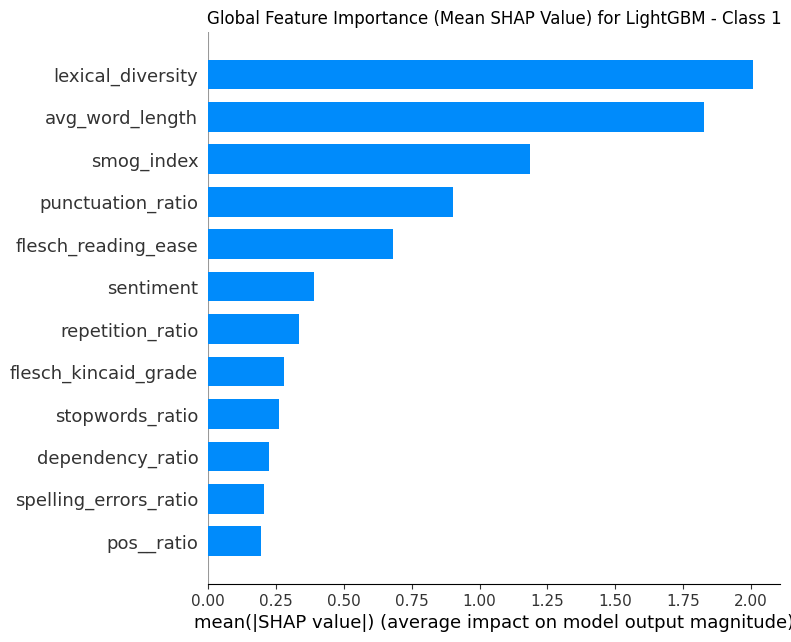

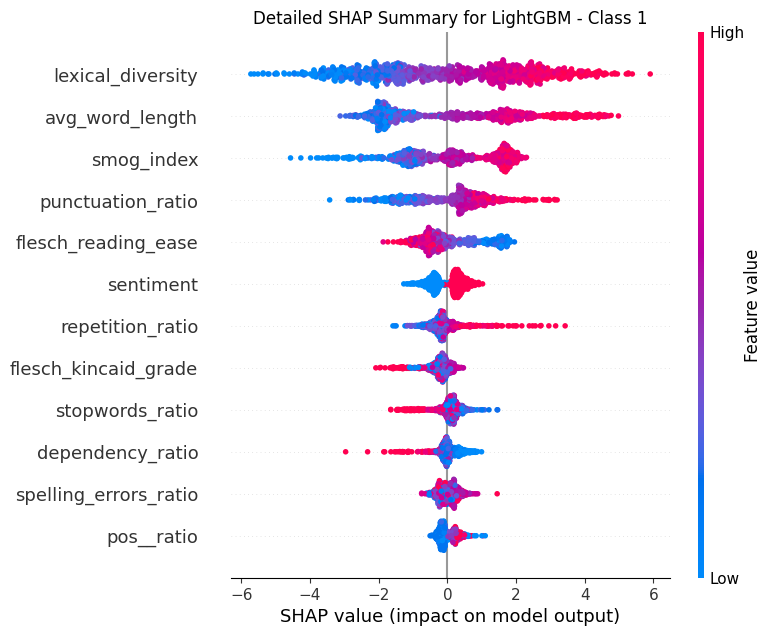

SHAP values shape for XGBoost: (934, 12)


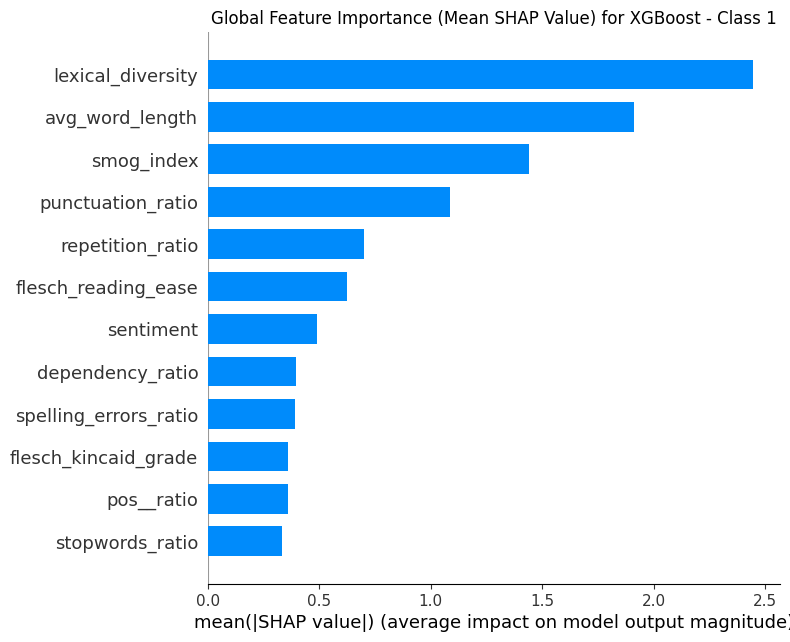

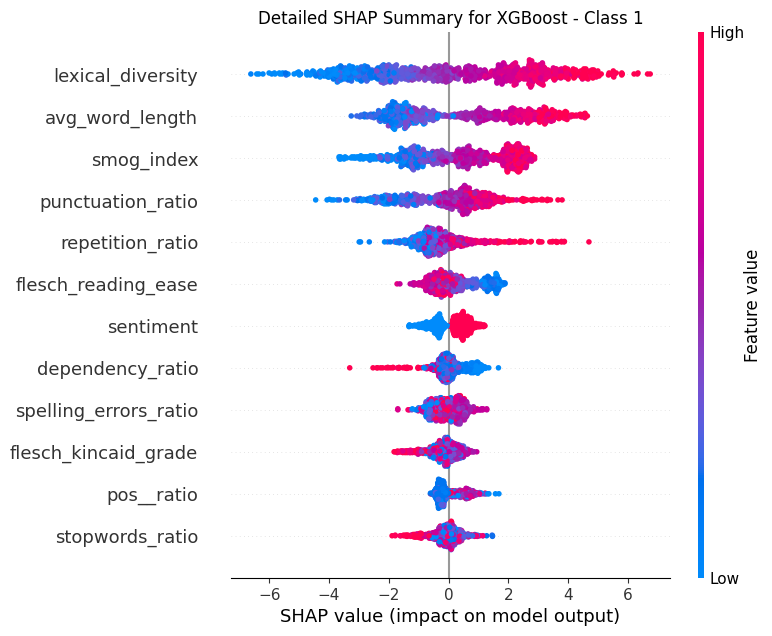

In [ ]:
import shap
import matplotlib.pyplot as plt

# SHAP analysis function
def shap_analysis(model, model_name, X_train, X_test):
    # Initialize the SHAP explainer for the model
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)

    # Select the SHAP values for the positive class (class 1) if it's a list (binary classification)
    if isinstance(shap_values, list):
        shap_values = shap_values[1]  # Use the SHAP values for class 1 in binary classification

    # Print SHAP values shape to verify consistency
    print(f"SHAP values shape for {model_name}:", shap_values.shape)

    # Feature importance plot (mean SHAP values)
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test, plot_type="bar", show=False)
    plt.title(f"Global Feature Importance (Mean SHAP Value) for {model_name} - Class 1")
    plt.show()

    # Detailed SHAP summary plot for individual SHAP values
    plt.figure(figsize=(10, 6))
    shap.summary_plot(shap_values, X_test, show=False)
    plt.title(f"Detailed SHAP Summary for {model_name} - Class 1")
    plt.show()

# Train the models on the selected data
X_train, X_test, y_train, y_test = train_test_split(final_internal_df[selected_features], final_internal_df['generated'], test_size=0.2, random_state=42)

# Instantiate and train LightGBM model
lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train)
shap_analysis(lgbm, "LightGBM", X_train, X_test)

# Instantiate and train XGBoost model
xgb = XGBClassifier()
xgb.fit(X_train, y_train)
shap_analysis(xgb, "XGBoost", X_train, X_test)

# Modelt Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier

# Define hyperparameter grids
lightgbm_param_grid = {
    'num_leaves': np.arange(20, 150, 10),
    'max_depth': [-1, 5, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 300],
    'min_child_samples': [10, 20, 30, 40]
}

xgboost_param_grid = {
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_weight': [1, 5, 10]
}

# Initialize models
lightgbm = LGBMClassifier(random_state=42)
xgboost = XGBClassifier(random_state=42)

# Setup RandomizedSearchCV
lightgbm_search = RandomizedSearchCV(
    estimator=lightgbm,
    param_distributions=lightgbm_param_grid,
    n_iter=50,
    scoring='f1',
    cv=5,
    random_state=42,
    n_jobs=-1
)

xgboost_search = RandomizedSearchCV(
    estimator=xgboost,
    param_distributions=xgboost_param_grid,
    n_iter=50,
    scoring='f1',
    cv=5,
    random_state=42,
    n_jobs=-1
)

# Perform tuning on LightGBM
print("Tuning LightGBM...")
lightgbm_search.fit(X_train, y_train)
print("Best parameters for LightGBM:", lightgbm_search.best_params_)
print("Best F1 score for LightGBM:", lightgbm_search.best_score_)

# Perform tuning on XGBoost
print("\nTuning XGBoost...")
xgboost_search.fit(X_train, y_train)
print("Best parameters for XGBoost:", xgboost_search.best_params_)
print("Best F1 score for XGBoost:", xgboost_search.best_score_)

# Evaluate the best models using the reusable function
print("\nEvaluating tuned LightGBM model on test data:")
evaluate_model(lightgbm_search.best_estimator_, X_train, X_test, y_train, y_test)

print("\nEvaluating tuned XGBoost model on test data:")
evaluate_model(xgboost_search.best_estimator_, X_train, X_test, y_train, y_test)
 # Add this code snippet to format and display results in a clear way
print("\n--- Model Tuning Results ---")
print(f"Best parameters for LightGBM: {lightgbm_search.best_params_}")
print(f"Best F1 score for LightGBM: {lightgbm_search.best_score_}")
print("\nEvaluated metrics for LightGBM on test data:")
for metric, value in evaluate_model(lightgbm_search.best_estimator_, X_train, X_test, y_train, y_test).items():
    print(f"{metric}: {value:.4f}")

print("\n--- Model Tuning Results for XGBoost ---")
print(f"Best parameters for XGBoost: {xgboost_search.best_params_}")
print(f"Best F1 score for XGBoost: {xgboost_search.best_score_}")
print("\nEvaluated metrics for XGBoost on test data:")
for metric, value in evaluate_model(xgboost_search.best_estimator_, X_train, X_test, y_train, y_test).items():
    print(f"{metric}: {value:.4f}")



Tuning LightGBM...
[LightGBM] [Info] Number of positive: 1830, number of negative: 1906
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000863 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2581
[LightGBM] [Info] Number of data points in the train set: 3736, number of used features: 12
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.489829 -> initscore=-0.040691
[LightGBM] [Info] Start training from score -0.040691
Best parameters for LightGBM: {'num_leaves': 50, 'n_estimators': 100, 'min_child_samples': 20, 'max_depth': -1, 'learning_rate': 0.1}
Best F1 score for LightGBM: 0.9501055777518055

Tuning XGBoost...
Best parameters for XGBoost: {'subsample': 1.0, 'n_estimators': 200, 'min_child_weight': 1, 'max_depth': 10, 'learning_rate': 0.2, 'colsample_bytree': 0.6}
Best F1 score for XGBoost: 0.9483068375790646

Evaluating tuned LightGBM model on test data:
[LightGBM] [Info] Number of positive: 183